In [3]:
# silly autoreload to avoid restarting the kernel every time
%load_ext autoreload
%autoreload 2

import gc
import time
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from ekf.plotting import plotter
from ekf.utils import add_noise_with_snr
from ekf.filters.config import DynamicsConfig
from ekf.filters.ekf import EKF
from scipy.integrate import odeint


seed = 29
np.random.seed(seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# EKF-SINDy with reaction-diffusion PDE (in POD space)

Consider a reaction-diffusion PDE

$$
\begin{align}
u_t &= 0.1\nabla^2 u +(1-A^2)u + \mu A^2 v,\\
v_t &= 0.1\nabla^2 v - \mu A^2 u + (1 - A^2)v,\\
A^2 &= u^2+v^2.
\end{align}
$$

with a periodic starting condition

$$
\begin{align}
u(x, y,0;\beta)&=\tanh\bigg(\beta\sqrt{x^2+y^2}\cos\bigg(\angle(x+iy)-\beta\sqrt{x^2+y^2}\bigg)\bigg),\\
v(x,y,0;\beta)&=\tanh\bigg(\beta\sqrt{x^2+y^2}\sin\bigg(\angle(x+iy)-\beta\sqrt{x^2+y^2}\bigg)\bigg).

\end{align}
$$

We consider simulations for $\beta=1.1$ and $\mu \in [0.8, 1.6]$. We consider a $\Delta t = 0.05$ with a time window $T=60$. The spatial domain is $[-L, L]^2$ for L = 10, and the spatial step is $\Delta h = 0.4$.

## Selecting POD modes

We extracte the simulated data and compute the top 20 modes. It is well known that the spiral reaction-diffusion PDE is characterized by two oscillating modes. However, these only capture spatial information, hence we must be careful if we try to identify the temporal dynamics with such modes.

In [5]:
# Extract data, and stack it

start_t = time.time()
filename = "/home/carlos/VSCodeProjects/EKF-VINDy/simulation_data/rd_spiral/rd_spiral_mu_0.800_to_1.600_d1_0.01_d2_0.01_m_1_beta_1.1.npz"

data = np.load(filename)

print(f"Data loaded in {time.time() - start_t:.4f} seconds.")

# Reshape data, the third dimension are the number of parameter instances

u = data['u']
v = data['v']
t = u.shape[2]

flat_dim = u.shape[0] * u.shape[1]

mu_instances = u.shape[3]

u = u.reshape((flat_dim, t, mu_instances))
v = v.reshape((flat_dim, t, mu_instances))

u_matrix = u.reshape((flat_dim, t * mu_instances))
v_matrix = v.reshape((flat_dim, t * mu_instances))


full_uv = np.vstack((u_matrix, v_matrix))

k = 20
start_t = time.time()
U, S, VT = svds(full_uv, k=k, which='LM')
print(f"SVD computed in {time.time() - start_t:.4f} seconds.")

# Since the matrix is big, just get rid of them after computing the SVD
del u, v, u_matrix, v_matrix, full_uv, data
gc.collect()


Data loaded in 0.0010 seconds.
SVD computed in 14.0072 seconds.


22

Generate trajectories in the undamped case and train SINDy...

x_train.shape: (20, 1000, 2)
(x0)' = 0.995 x1
(x1)' = -0.999 x0 + -0.523 x1 + -0.987 x0^3 + -0.468 x1^3


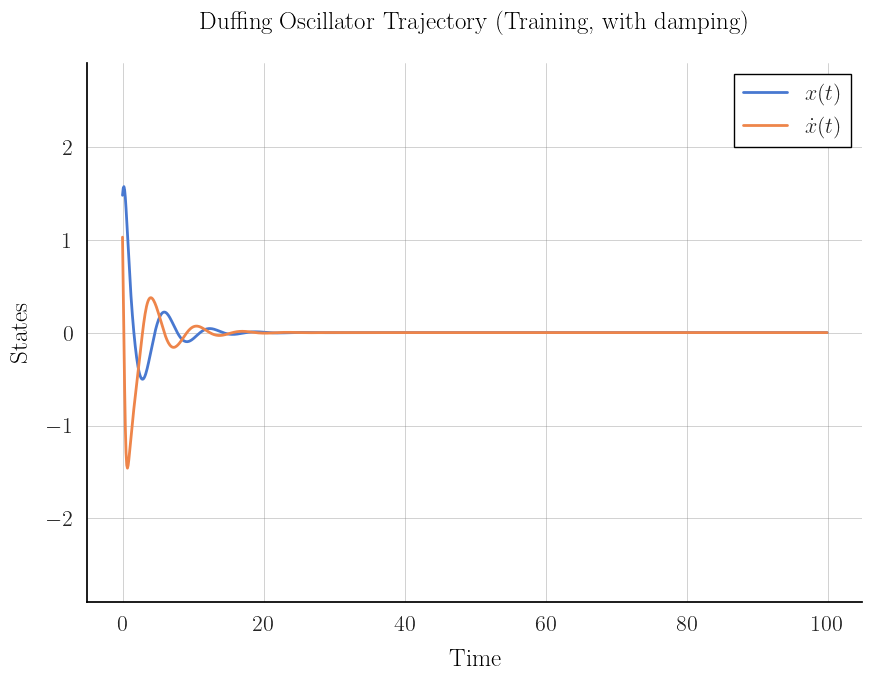

In [7]:
params = {
    'alpha': 1,   # Linear stiffness
    'beta': 1,     # Nonlinear stiffness
    'delta_1': 0.5,  # Linear damping 
    'delta_2': 0.5,  # Cubic damping 
}

# Generate training data (around [1.5, 0] initial condition)
t_conservation = 100.0 # energy is depleted by then

n_train = 20
std = 0.01
mean_ic = np.array([1.5, 1.0])
x_0 = np.random.randn(n_train, 2) * std + mean_ic
time_instances = np.arange(0, 100, 0.1)
x_train = []



for i in range(n_train):
    sol = odeint(duffing_oscillator, x_0[i, :], time_instances, args=(params, t_conservation))
    x_train.append(sol)

print(f'x_train.shape: {x_train.shape}')
x_train = [noisy_traj for noisy_traj in add_noise_with_snr(x_train, snr=500)]


model = ps.SINDy(feature_names=['x0', 'x1'],
                 feature_library=ps.PolynomialLibrary(degree=3),
                 optimizer=ps.STLSQ(threshold=5e-2))

model.fit(x_train, t=0.1, multiple_trajectories=True)
model.print()

# plot one trajectory from x_train
fig, ax = plotter.plot_trajectory(x_train[0], time_instances, title='Duffing Oscillator Trajectory (Training, with damping)', xlabel='Time', ylabel='States',
                                   state_names=["$x(t)$", "$\dot{x}(t)$"], ylim=(-2.9, 2.9), x_tick_skip=20)
# plt.savefig("/home/carlos/Downloads/duffing_training_with_damping.svg", bbox_inches='tight')
plt.show()

What if system suddenly becomes conservative? So the damping term $\delta$ goes to zero abruptly. We define the constraint object and set a very small noise (can you do the update at the same time?)

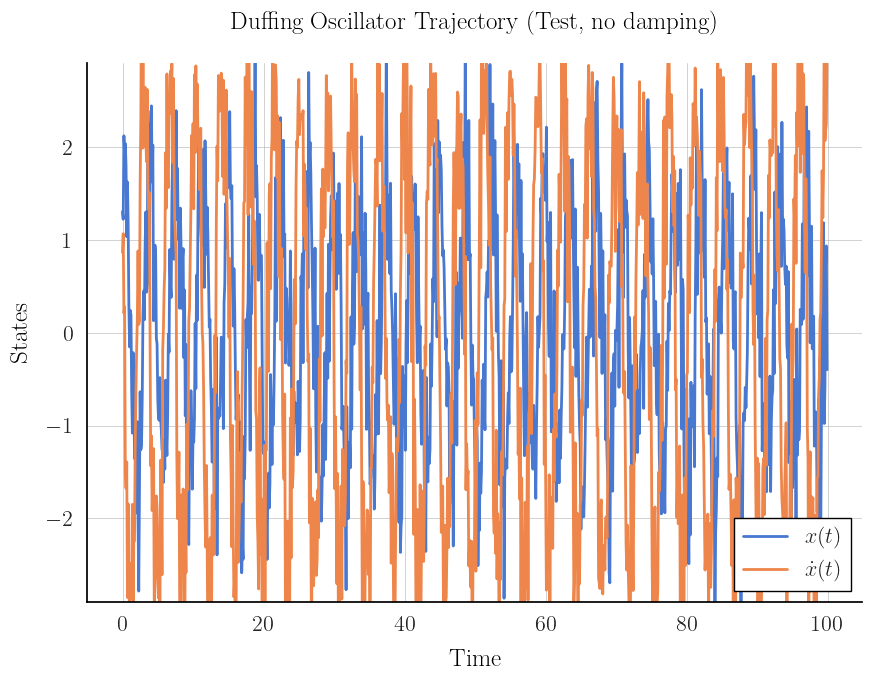

In [50]:
t_conservation = 0.0
time_instances = np.arange(0, 100, 0.1)
x_0_test = np.random.randn(1, 2) * std + mean_ic
x_test = odeint(duffing_oscillator, x_0_test[0, :], time_instances, args=(params, t_conservation))
x_test_noiseless = x_test.copy()
x_test = add_noise_with_snr(x_test, snr=8)

fig, ax = plotter.plot_trajectory(x_test, time_instances, x_tick_skip=20, title='Duffing Oscillator Trajectory (Test, no damping)', xlabel='Time', ylabel='States',
                                   state_names=["$x(t)$", "$\dot{x}(t)$"], ylim=(-2.9, 2.9))

# plt.savefig("/home/carlos/Downloads/duffing_test_no_damping.svg", bbox_inches='tight')
plt.show()

And now we setup the Kalman filter

library_terms: ['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2', 'x0^3', 'x0^2 x1', 'x0 x1^2', 'x1^3']
alpha: 0.9989760833765027, beta: 0.9868430935432442


Processing: 100%|██████████| 999/999 [00:00<00:00, 3045.14it/s]


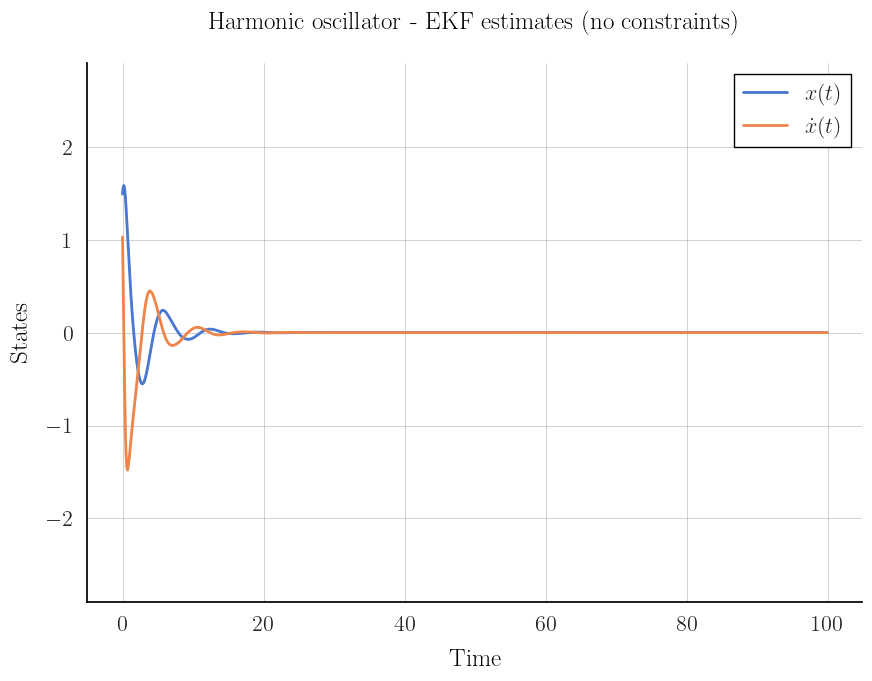

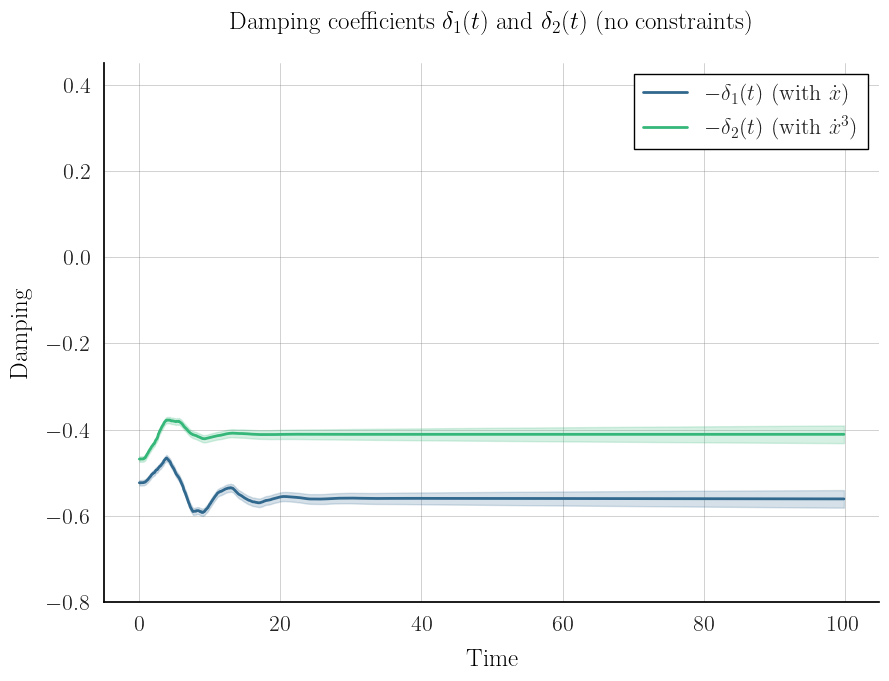

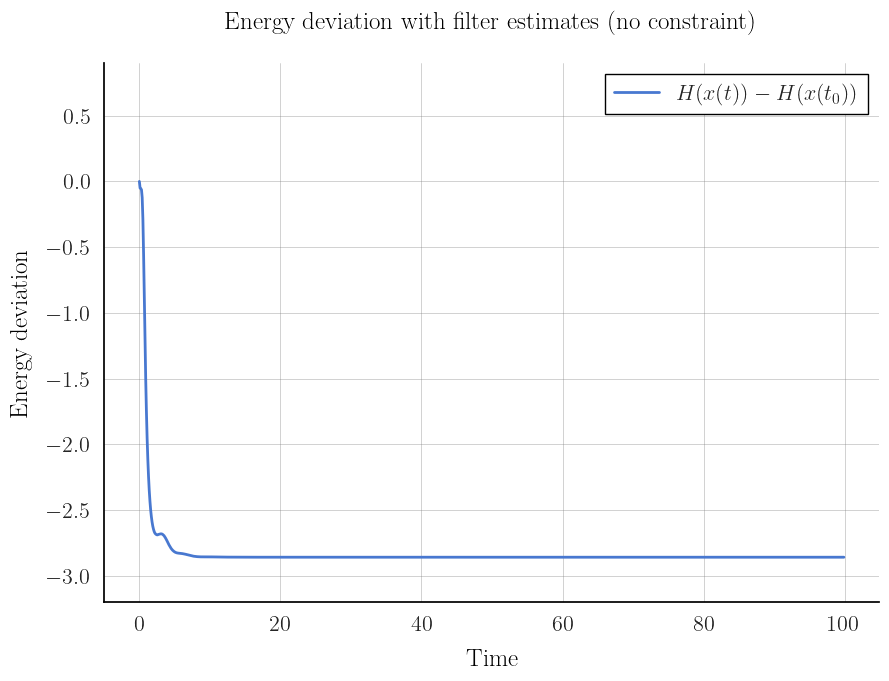

In [57]:
from ekf_vindy.plotting import plotter
from ekf_vindy.filters.ekf import EKF

# EKF configuration (linear and cubic damping have indices 2 and 3 in x_cal)
p0 = np.diag([1e-8, 1e-8, 1e-5, 1e-5]) # initial state covariance
q = np.diag([1e-8, 1e-8, 1e-6, 1e-6]) # process noise covariance
r = np.diag([4e-3, 4e-3])

library_terms = model.get_feature_names()
coeffs = model.coefficients()
variables = model.feature_names
print(f'library_terms: {library_terms}')

# correcting the sign for correct energy computation
# delta_1, delta_2 = -coeffs[1][2], -coeffs[1][9]
alpha, beta = -coeffs[1][1], -coeffs[1][6]
print(f'alpha: {alpha}, beta: {beta}')
tracked_terms = [[],
               [2, 9]]

x0 = x_0_test[0, :]
config = DynamicsConfig(variables, library_terms, tracked_terms, coeffs, q, r)
filter = EKF(x0, p0, config=config, integration_rule='RK4')

dts = np.diff(time_instances)
observations = x_test[1:, :]
filter.run_filter(dts, observations)

filter_estimates = filter.states.xcal_states[:, 0:2]
sdevs = filter.states.sdev_states[:, 0:2]

fig, x = plotter.plot_trajectory(filter_estimates, time_instances, sdevs, x_tick_skip=20, title='Harmonic oscillator - EKF estimates (no constraints)', xlabel='Time', ylabel='States', 
                                 state_names=["$x(t)$", "$\dot{x}(t)$"], ylim=(-2.9, 2.9))
# plt.savefig("/home/carlos/Downloads/duffing_no_constraint.svg", bbox_inches='tight')
plt.show()
damping_term = filter.states.xcal_states[:, [2, 3]]
damping_sdev = filter.states.sdev_states[:, [2, 3]]

fig, x = plotter.plot_trajectory(damping_term, time_instances, damping_sdev, x_tick_skip=20, title="Damping coefficients $\delta_1(t)$ and $\delta_2(t)$ (no constraints)", xlabel='Time', ylabel='Damping',
                                 state_names=["$-\delta_1 (t)$ (with $\dot{x}$)", "$-\delta_2 (t)$ (with $\dot{x}^3$)"], palette="viridis",
                                 ylim=(-0.8, 0.45))
# plt.savefig("/home/carlos/Downloads/duffing_damping_no_constraint.svg", bbox_inches='tight')
plt.show()
# compute energy
def compute_dE(x, x0):
     return np.array([energy(x, alpha, beta) - energy(x0, alpha, beta)])
delta_x0 = lambda x: compute_dE(x, x0)

# is energy conserved?
energy_diff = [delta_x0(xi) for xi in filter_estimates]
energy_diff = np.array(energy_diff)
fig, ax = plotter.plot_trajectory(energy_diff, time_instances, x_tick_skip=20, title='Energy deviation with filter estimates (no constraint)', xlabel='Time', ylabel='Energy deviation', 
                                  state_names=["$H(x(t)) - H(x(t_0))$"], ylim=(-3.2, 0.9))
# plt.savefig("/home/carlos/Downloads/duffing_energy_no_constraint.svg", bbox_inches='tight')
plt.show()



Now let's consider the energy conservation constraint (from $t=0$)